In [1]:
# 1. Get essential libraries
from vnstock import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

Observations:  1630


<Axes: xlabel='Time'>

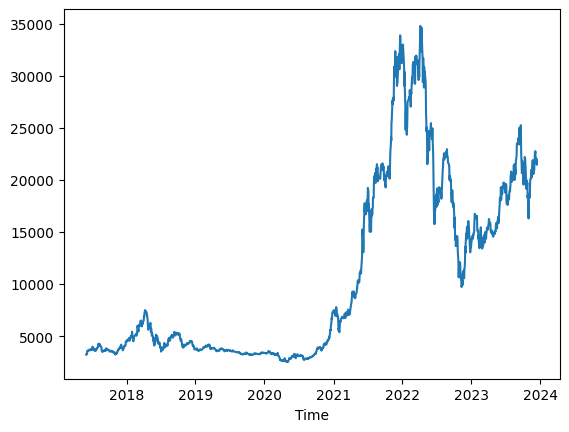

In [2]:
#2. Fetch data and visualize
# VND
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
VND
VND["Close"].plot()

In [3]:
# Preprocessing
df = pd.DataFrame(VND['Close'])
df = df.dropna() 
df = df.reset_index(drop=True)
df

,Close
0,3230
1,3280
2,3280
3,3320
4,3590
...,...
1625,21950
1626,22050
1627,21600
1628,21450


In [4]:
# Check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Close'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
#Not stationary

ADF stat: -1.199031
p-value: 0.674012


In [5]:
adf2 = adfuller(df['Close'].diff().dropna(), regression ='c', maxlag=30)
print("ADF stat: %f" % adf2[0])
print("p-value: %f" % adf2[1])
#Stationary

ADF stat: -5.780095
p-value: 0.000001


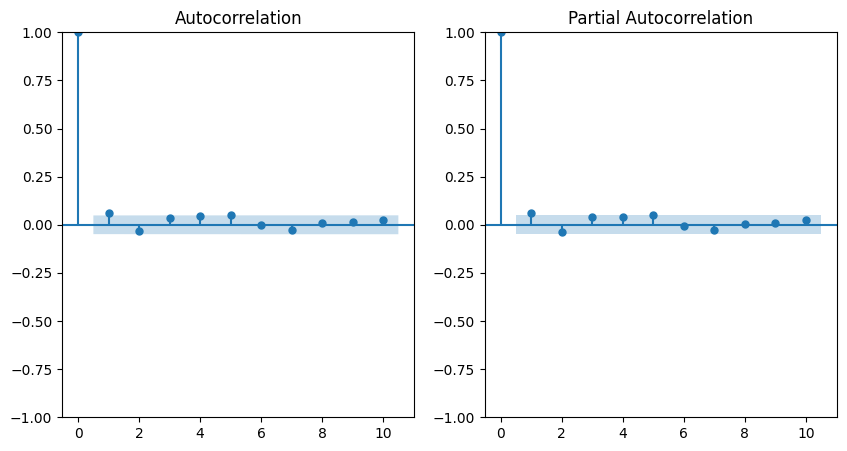

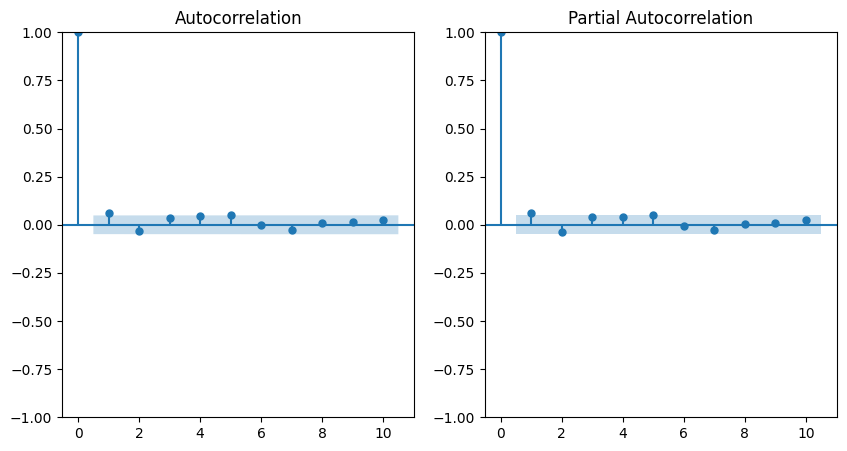

In [6]:
# Difference the data and plot the acf
fig, ax = plt.subplots(1,2,figsize=(10,5))
#ACF
sm.graphics.tsa.plot_acf(np.diff(df['Close']),lags=10, ax=ax[0])
# PACF
sm.graphics.tsa.plot_pacf(np.diff(df['Close']),lags=10, ax=ax[1])

In [7]:
#3. Slit the data into train : 
# Test with ratio 8:2
train_size82 = int(0.8 * len(df))
test_size82 = int(0.2 * len(df))

train_data82 = df[:train_size82]
test_data82 = df[train_size82:]

In [8]:
# 4. Training process
# 8 : 2 RATIO
x_train82 = np.array(train_data82.index).reshape(-1, 1)
y_train82 = np.array(train_data82['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

model82 = auto_arima(y_train82, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model_fit82 = model82.fit(y_train82)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19454.676, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19467.668, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19456.802, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19455.638, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19467.124, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19458.074, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=19457.892, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19456.404, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19456.116, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=19454.683, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=19457.704, Time=0.23 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] 

In [9]:
# 5. Testing process
# 8:2 RATIO
x_test82 = np.array(test_data82.index).reshape(-1, 1)
y_test82 = np.array(test_data82['Close'])
y_pred82 = model82.predict(n_periods=len(y_test82))

In [10]:
# 6. 60 days prediction
# 8:2 RATIO
last_index82 =  df.index[-1]
last_data82 =pd.RangeIndex(start=last_index82, stop=last_index82 + 60, step=1)

#create an array of 60 integers starting from last index
x_next_60_days82 = np.array(range(last_index82 + 1, last_index82 + 61)).reshape(-1, 1)

#predict the price for the next 60 days.
y_next_60_days82 = model82.predict(len(x_next_60_days82))

#print the prices for the next 60 days.
print('Predicted prices for the next 60 days: ')
print(y_next_60_days82)

Predicted prices for the next 60 days: 
[21724.61288002 21729.22878015 21722.63610947 21731.59968162
 21749.28035305 21754.85936275 21753.65893403 21761.87274593
 21775.35904373 21781.52172541 21783.58390434 21791.34334064
 21802.29180812 21808.80821086 21812.84444958 21820.32852227
 21829.74146078 21836.47222753 21841.70288256 21849.02007807
 21857.5039359  21864.36461241 21870.31795591 21877.53401994
 21885.45573218 21892.39513694 21898.78574722 21905.94052338
 21913.52210622 21920.50922196 21927.164403   21934.28203746
 21941.65782308 21948.67385261 21955.48911367 21962.58423956
 21969.83550642 21976.86905822 21983.78117661 21990.86266191
 21998.038588   22005.08275859 22012.05348104 22019.12669993
 22026.25704067 22033.30764641 22040.31382756 22047.38203689
 22054.48479596 22061.53930149 22068.56693713 22075.6321106
 22082.71818123 22089.77505007 22096.81566687 22103.87900058
 22110.95497377 22118.01327481 22125.06174593 22132.12396472]


In [12]:
# 7. Evaluation
# 8 : 2 RATIO
#RMSE
test_rmse = np.sqrt(np.mean((y_pred82 - y_test82)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test82 - y_pred82) / y_test82)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred82 - y_test82))
print('Testing MAE:', test_mae)

def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("Testing MSLR: ", MSLE(y_pred82, y_test82))

Testing RMSE: 6365.051393317954
Testing MAPE: 37.8708183859328
Testing MAE: 5653.634985483566
Testing MSLR:  0.12624100413801045


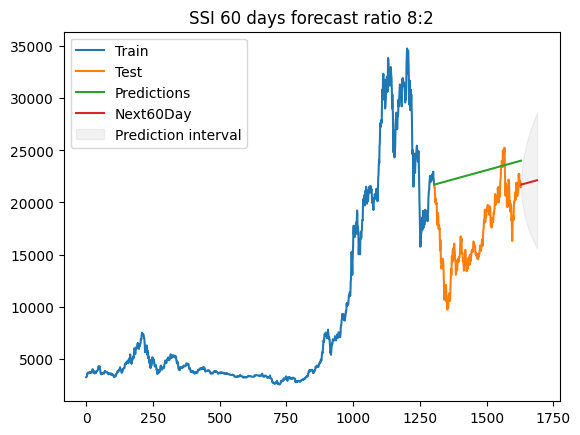

In [24]:
# 8. Visualize the result
# Forecast
n_periods = 60
fc, confint = model_fit82.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Close']), len(df['Close'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train_data82.index, train_data82['Close'])
plt.plot(test_data82.index, test_data82['Close'])
plt.plot(test_data82.index, y_pred82)

plt.plot(fc_series)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05)
plt.legend(['Train', 'Test', 'Predictions','Next60Day', 'Prediction interval'])

plt.title("SSI 60 days forecast ratio 8:2")
plt.show()